### Compare reweighting techniques


The idea behind this notebook is to compare two reweighting techniques. One can reweight one distribution $p_0(x)$ to look like another distribution $p_1(x)$ by calculating a weight defined as $r=p_1(x)/p_0(x)$ and apply this weight to $p_0(x)$. 

The first reweighting technique is calculating the $r$ with $x=VpT$ and number of jets (that learns "2D weights"). As this method is only able to capture features in two dimensions, there is a possibility that some features are not accounted for in the weights. 
The second reweighting technique (that learns "CARL weights") is based on [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273), which can take into account the full space instead of just two dimensions. In this notebook the carl weights are learned, and the 2D weights are loaded from a separate source. 

The performance of the weights, i.e. how well the reweighted original distribution matches the target distribution, is assessed by training a discriminator to differentiate the original distribution with weights applied from a target distribution.  

Work in progress by Leonora Vesterbacka. This notebook is based on the work by Kyle Cranmer, Juan Pavez, Gilles Louppe, March 2016. 

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import theano
from scipy.stats import chi2
from itertools import product
import root_numpy
import pandas as pd
import uproot
np.random.seed(314)

In [5]:
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier

# other classifiers from scikit-learn that you could also use
from sklearn.ensemble import ExtraTreesRegressor

# for calibration
from sklearn.model_selection import StratifiedShuffleSplit
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV

In [6]:
#the example has much more real data than monte carlo
#this leads to unbalanced dataset
#some techniques deal with that better than others
data_to_use = ["all"][0]

#if you use all the data the classifier score can be very peaked
#some classifiers can use weights (eg. the ExtraTreesRegressor)
#and that will make the distribution less peaked.
clf_type = ["mlp","trees","trees with weights"][0]

# the histogram and kde calibration don't work very well
#with very peaked output score distributions,
#but the isotonic approach does
calibration_type = ["isotonic", "kde", "histogram"][2]

#do either training using all phase space by defining do = "varAll", or just two variables by defining do = "var2"
do = ["two", "all"][1]

In [7]:
if do == "two":
    binning = [range(0, 3000, 200), range(0, 15, 1)]
    variables = ['VpT','Njets']
    weights = ['truthWeight','learnWeight2D_MUR2']
if do == "all":
    etaV = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    etaJ = [-3.2,-2.8,-2.4,-2,-1.6,-1.2,-0.8,-0.4,0,0.4,0.8,1.2,1.6,2,2.4,2.8,3.2]
    variables = ['VpT','Njets','j1pT', 'j2pT', 'HT','ptmiss', 'l1pT','Veta','j1eta','j2eta']
    binning = [range(0, 3000, 200), range(0, 15, 1), range(0, 3000, 200),range(0, 3000, 200),range(0, 3000, 200),range(0, 1000, 100),range(0, 1000, 100), etaV, etaJ, etaJ]
    weights = ['truthWeight','learnWeight2D_MUR2']
    #truthWeight is the generator weight
    #learnWeight2D_MUR2 is the 2D weight that is to be compared to the carl weights

#get original and target samples, muR = 1:original, muR = 2:target
variablesMUR1 = root_numpy.root2array('/eos/user/m/mvesterb/data/MUR1_MUF1_PDF261000.root', branches=variables)
variablesMUR2 = root_numpy.root2array('/eos/user/m/mvesterb/data/MUR2_MUF1_PDF261000.root', branches=variables)
#get separate samples with the weights, (will not be used for training, just for resampling)
weightsMUR1 = root_numpy.root2array('/eos/user/m/mvesterb/data/MUR1_MUF1_PDF261000.root', branches=weights)
weightsMUR2 = root_numpy.root2array('/eos/user/m/mvesterb/data/MUR2_MUF1_PDF261000.root', branches=weights)

#create dataframes to do the training on
dfMUR1 = pd.DataFrame(variablesMUR1,columns=variables)
dfMUR2 = pd.DataFrame(variablesMUR2,columns=variables)
dfWMUR1 = pd.DataFrame(weightsMUR1,columns=weights)
dfWMUR2 = pd.DataFrame(weightsMUR2,columns=weights)

### A word on the data

There are two MC samples currently available, MUR1_MUF1_PDF261000 ($p_0(x)$ or "original distribution") and MUR2_MUF1_PDF261000 ($p_1(x)$ or "target distribution"). The samples are identical in every single kinematic variable and the only generator difference, i.e. muR = 2 vs muR = 1, is contained in the variable truthWeight. To take into account this difference, both samples are resampled according to this truthWeight.  

The point of this notebook is to compare two reweighting techniques, weights learned from a 2D parameterization and weights learned using carl. The purpose of the reweighting is to go from one original distribution to a target distribution. The true weight is available (as truthWeight), which represents the difference between the original and the target distributions. A discriminator is trained to differentiate the original and the target distributions from each other, as well as differentiating the target distribution from the original distributions with the learned carl or 2D weights applied. Well learned weights would make the target and reweighted distributions very similar and indistinguishable for the discriminator. 

In [8]:
#use the weight dataframes to create probability distributions according to the truthWeight
pTruthMUR1    = (dfWMUR1.truthWeight)/np.sum(dfWMUR1.truthWeight.astype(np.float))
pTruthMUR2    = (dfWMUR2.truthWeight)/np.sum(dfWMUR2.truthWeight.astype(np.float))
iTruthMUR1    = np.random.choice(np.arange(len(dfMUR1)),size=int(np.sum(dfWMUR1.truthWeight.astype(np.float))),p=pTruthMUR1)
iTruthMUR2    = np.random.choice(np.arange(len(dfMUR2)),size=int(np.sum(dfWMUR2.truthWeight.astype(np.float))),p=pTruthMUR2)
truthMUR1     = dfMUR1.iloc[iTruthMUR1] #original
truthMUR2     = dfMUR2.iloc[iTruthMUR2] #target

#to randomize training and test data
n_target = truthMUR1.values.shape[0]
randomized_originalCARL = truthMUR1.values[np.random.choice(range(truthMUR1.values.shape[0]),2*n_target,replace=True)]

X0_all = randomized_originalCARL[:n_target,:]

X0_testCARL = randomized_originalCARL[n_target:,:]

X1_all = truthMUR2.values

print(X0_all.shape)
print(X0_testCARL.shape)

(243655, 10)
(243655, 10)


### The unweighted 1-d distributions

Define a function that plots the original and target distributions

In [9]:
hist_settings0 = {'alpha': 0.3}
hist_settings1 = {'histtype':'step', 'color':'black', 'linewidth':1, 'linestyle':'--'}

def drawResampledDistributions(h1, h2):
    for id, v in enumerate(variables, 1):
        plt.figure(figsize=(4, 3))
        plt.yscale('log')
        plt.hist(h1[v], bins = binning[id-1], label = 'muR = 1',**hist_settings0)
        plt.hist(h2[v], bins = binning[id-1], label = 'muR = 2',**hist_settings1)
        plt.legend(title='resampled')
        plt.xlabel('%s'%(v)) 
        axes = plt.gca()
        axes.set_ylim([1,1000000])
        plt.savefig('plots/resampled_%s.png'%(v))
            
def drawReweightedDistributions(h1, h2):
    for id, v in enumerate(variables, 1):
        plt.figure(figsize=(4, 3))
        plt.hist(h1[v], bins = binning[id-1],weights = dfWMUR1.truthWeight, label = 'muR = 1', **hist_settings0)
        plt.hist(h2[v], bins = binning[id-1],weights = dfWMUR2.truthWeight, label = 'muR = 2', **hist_settings1)
        plt.yscale('log')
        plt.legend(title='reweighted')
        plt.xlabel('%s'%(v))  
        axes = plt.gca()
        axes.set_ylim([1,1000000])
        plt.savefig('plots/reweighted_%s.png'%(v))


Test that the resampled and reweighted distributions give the same result

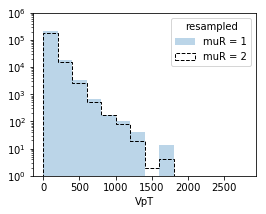

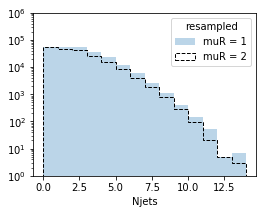

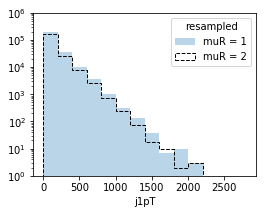

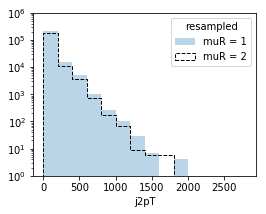

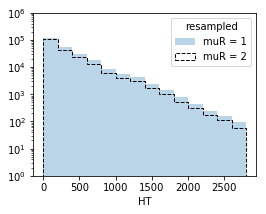

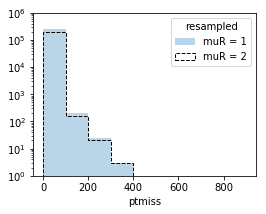

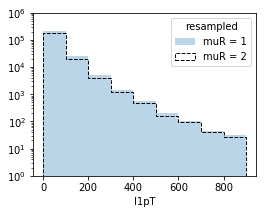

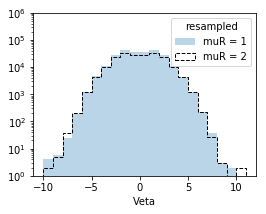

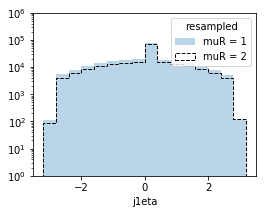

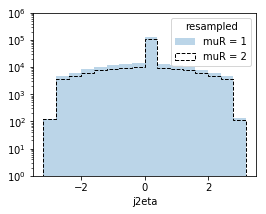

In [10]:
drawResampledDistributions(truthMUR1,truthMUR2)

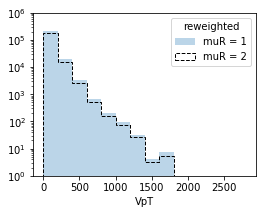

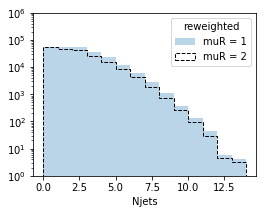

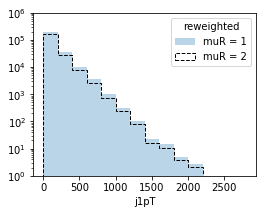

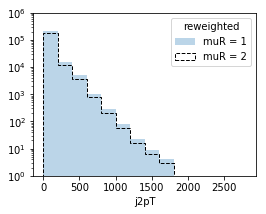

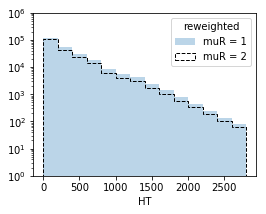

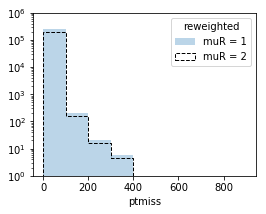

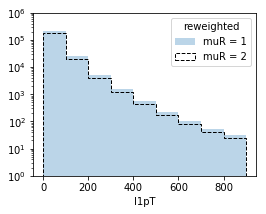

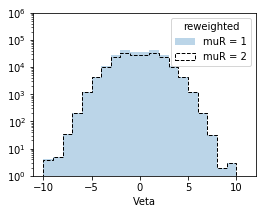

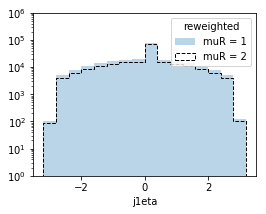

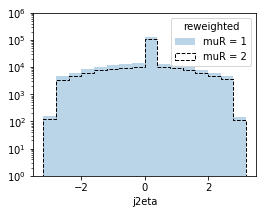

In [11]:
drawReweightedDistributions(dfMUR1, dfMUR2)

In [12]:
# make training data from all samples
num1 = X0_all.shape[0]
num2 = X1_all.shape[0]
X_all = np.vstack((X0_all,X1_all))
y_all = np.ones(num1 + num2, dtype=np.int)
y_all[num1:] = 0

#weight X0 or X1 so weighted samples are balanced
training_weights=np.ones(num1+num2)
#if num1>num2 apply weight < 1 to the num1 samples
training_weights[:num1] = np.minimum(1.,1.*num2/num1)
#vice versa
training_weights[num1:] = np.minimum(1.,1.*num1/num2)

#randomly sample X0 to have the same number of entries as X1
# assuming X0 is bigger here
X0_s = X0_all[np.random.choice(range(X0_all.shape[0]),num2,replace=False)]
X_s = np.vstack((X0_s,X1_all))
y_s = np.ones(num2 + num2, dtype=np.int)
y_s[num2:] = 0

X, X0, X1, y = None, None, None, None
X, X0, X1, y = X_s, X0_s, X1_all, y_s

print(X0.shape)
print(X1.shape)

(201775, 10)
(201775, 10)


### Learning the carl weights

This approach is based on [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273). 

We will use the [carl](https://github.com/diana-hep/carl) package to approximate the likelihood ratio by first training a neural network classifier and then calibrating the output to be the likelihood ratio. Any other type of classifier could also be used.

In [13]:
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# configure the classifier and train it
classifier = None
if clf_type == "mlp":
    classifier = make_pipeline(StandardScaler(),
                   as_classifier(MLPRegressor(tol=1e-05, activation="logistic", 
                   hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
                   learning_rate="constant", solver="lbfgs", random_state=1, 
                   max_iter=75)))
    classifier.fit(X,y) 
elif clf_type =="trees":
    classifier = make_pipeline(StandardScaler(),
                       as_classifier(ExtraTreesRegressor(n_estimators=250, max_leaf_nodes=15)))
    classifier.fit(X,y) # unbalanced data
    
elif clf_type == "trees with weights":
    regressor = ExtraTreesRegressor(n_estimators=250, max_leaf_nodes=15)
    regressor.fit(X,y, sample_weight=training_weights) # unbalanced, weighted data
    classifier = as_classifier(ExtraTreesRegressor(n_estimators=250, max_leaf_nodes=15))
    classifier.regressor_ = regressor

elif clf_type == "trees with weights" and data_to_use == "max balanced":
    print("not implemented, use all data right now")

else:
    print("configuration error")

ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=classifier, 
        cv="prefit",  # keep the pre-trained classifier
        method=calibration_type, bins=100))
# now train calibrate the ratio 
ratio.fit(X=X, y=y, n_samples=y.size)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('wrapper', Wrapper(base_estimator=MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999...    bins=100, cv='prefit', interpolation=None, method='histogram',
            variable_width=False),
        random_state=None)

### Check the result of CARL weights on 1D distributions

The resampleWeights function resamples the samples according to the new carl weights

In [14]:
carl_weights = ratio.predict(X0)

carl/distributions/histogram.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.histogram_[all_indices]


In [15]:
def drawResampledDistributions(mur1, mur2, mur2w, wname):
    plt.figure(figsize=(20, 12))
    for id, v in enumerate(variables, 1):
        plt.subplot(3,5, id)
        plt.hist(mur1[v],  bins = binning[id-1], label = 'muR = 1', **hist_settings0)
        plt.hist(mur2w[v], bins = binning[id-1], label = 'muR = 1 * weight', **hist_settings0)
        plt.hist(mur2[v],  bins = binning[id-1], label = 'muR = 2', **hist_settings1)
        plt.yscale('log')
        plt.legend(title='weight = %s w/ %s variables'%(wname, do))
        plt.xlabel('%s' %(v))
        axes = plt.gca()
        axes.set_ylim([1,1000000])
    plt.savefig('plots/resampled_%sWeight_%sVariables.png'%(wname, do))

               
def resampleWeights(x, w):
    new = w.astype(np.double) / np.sum(w.astype(np.double))
    indices = np.random.choice(np.arange(len(x)),size=x.shape[0],p=new)
    weighted = x.iloc[indices]
    return (weighted)

def drawWeightResults(MUR1, MUR2, weight, wname):
    mur1Truth   = resampleWeights(MUR1, np.ones(MUR1.shape[0]))#resample according to a dummy weight of ones
    mur2Truth   = resampleWeights(MUR2, np.ones(MUR2.shape[0]))
    mur2Learned = resampleWeights(MUR2, weight)                #resample according to carl weights
    drawResampledDistributions(mur1Truth, mur2Truth, mur2Learned, wname)

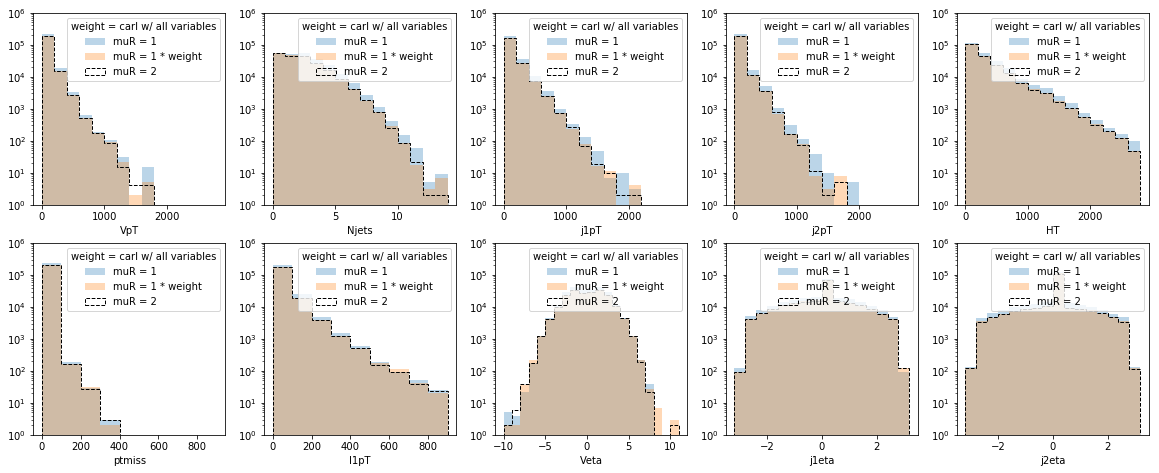

In [16]:
drawWeightResults(truthMUR1, truthMUR2, carl_weights, 'carl')

### Learning the 2D weights


The 2D weights are derived in a separate script, and simply loaded here as weight called learnWeight2D_MUR2

In [17]:
#resample the samples according to the truthWeight*learnWeight2D_MUR2, i.e. "apply 2D weight to original sample"
pLearn2DMUR2  = (dfWMUR1.truthWeight*dfWMUR1.learnWeight2D_MUR2)/np.sum(dfWMUR1.truthWeight.astype(np.double)*dfWMUR1.learnWeight2D_MUR2.astype(np.double))
iLearn2DMUR2  = np.random.choice(np.arange(len(dfMUR1)),size=int(np.sum(dfWMUR1.truthWeight.astype(np.double)*dfWMUR1.learnWeight2D_MUR2.astype(np.double))),p=pLearn2DMUR2)
learn2DMUR2   = dfMUR1.iloc[iLearn2DMUR2]

#to randomize training and test data
n_target = truthMUR2.values.shape[0]
randomized_original2D = learn2DMUR2.values[np.random.choice(range(learn2DMUR2.values.shape[0]),2*n_target,replace=True)]

X0_test2D = randomized_original2D[n_target:,:]

In [18]:
def draw2DDistributions(mur1, mur1w, mur2, wname):
    plt.figure(figsize=(20, 12))
    for id, v in enumerate(variables, 1):
        plt.subplot(3,5, id)
        plt.yscale('log')
        plt.hist(mur1[v],  bins = binning[id-1], label = 'muR = 1',**hist_settings0)
        plt.hist(mur1w[v], bins = binning[id-1], label = 'muR = 1 * weight',**hist_settings0)
        plt.hist(mur2[v],  bins = binning[id-1], label = 'muR = 2',**hist_settings1)
        plt.legend(title='')
        plt.legend(title='weight = 2D histo. division')
        plt.xlabel('%s' %(v))
        axes = plt.gca()
        axes.set_ylim([10,1000000])
    plt.savefig('plots/resampled_%sWeight.png'%(wname))

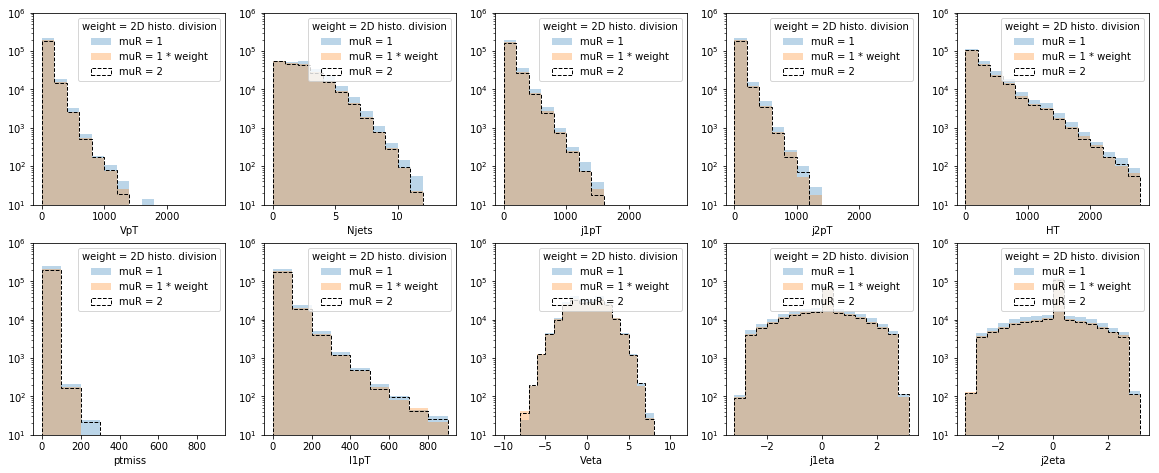

In [19]:
draw2DDistributions(truthMUR1, learn2DMUR2, truthMUR2, '2D')

## ROC curves for quantitative assessment of performance

We want to quantify how well the reweighted distribution matches target distribution, but this is challenging in high dimensions. So we will train a new classifier, call it the *discriminator*, that will try to predict if an event is from the reweighted distribution or the real target. If it can tell the difference, then we haven't done a good job in reweighting. If we have done a good job in reweighting, then we don't expect that it will be able to tell the difference and the ROC curve should just be a diagonal line with Area Under the Curve (AUC) of 0.5. 

*Note*: This is similar to the use of the discriminator in the paper [Generative Adversarial Nets](http://arxiv.org/abs/1406.2661).

We consider two ways of doing this
   * use a discriminator trained with data *resampled proportional to weights*. The advantage of this approach is that the discriminator only deals with unweighted events.
   * use a discriminator that can be *trained with weights*. 

The two approaches give similar results.

In [20]:
# generate some new data to make the ROC curve.
# if we used the same data we might be fooled by overfitting
X0_rocMUR1 = X0_testCARL
X0_rocMUR2 = X0_test2D
X1_roc = X1

# Weighted with approximate likelihood ratios from carl
carl_weights_roc = ratio.predict(X0_rocMUR1,log=False)
carl_weights_roc[np.isinf(carl_weights_roc)] = 0.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc

def weight_data(x0,x1,weights, max_weight=10000.):
    x1_len = x1.shape[0]
    x0_len = x0.shape[0]
    weights[weights>max_weight]=max_weight

    weights = weights / weights.sum()
    weighted_data = np.random.choice(range(x0_len), x0_len, p = weights)
    w_x0 = x0.copy()[weighted_data]
    y = np.zeros(x1_len + x0_len)
    x_all = np.vstack((w_x0,x1))
    y_all = np.zeros(x1_len +x0_len)
    y_all[x0_len:] = 1
    return (x_all,y_all)

def resampled_discriminator_and_roc(original, target, weights):   
    
    (data, labels) = weight_data(original,target,weights)
    W = np.concatenate([weights / weights.sum() * len(target), [1] * len(target)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51, test_size=0.49)    
    
    discriminator = MLPRegressor(tol=1e-05, activation="logistic", 
               hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
               learning_rate="constant", solver="lbfgs", random_state=1, 
               max_iter=75)

    discriminator.fit(Xtr,Ytr)

    predicted = discriminator.predict(Xts)

    fpr, tpr, _  = roc_curve(Yts,predicted.ravel())
    roc_auc = auc(fpr, tpr)
    return fpr,tpr,roc_auc


In [ ]:
fpr_t,tpr_t,roc_auc_t = resampled_discriminator_and_roc(X0_rocMUR1, X1_roc, np.ones(X0_rocMUR1.shape[0]))
plt.plot(fpr_t, tpr_t, label=r"no weight, AUC=%.3f" % roc_auc_t)
#applying weights that are just 1, i.e. no weights
fpr_t,tpr_t,roc_auc_t = resampled_discriminator_and_roc(X0_rocMUR1, X1_roc, carl_weights_roc)
plt.plot(fpr_t, tpr_t, label=r"$w_{learn}$ (carl with %s variables),  AUC=%.3f" %(do, roc_auc_t))
#applying carl weights
fpr_t,tpr_t,roc_auc_t = resampled_discriminator_and_roc(X0_rocMUR2, X1_roc, np.ones(X0_rocMUR2.shape[0]))
plt.plot(fpr_t, tpr_t, label=r"$w_{learn}$ (hist division, two variables),  AUC=%.3f" % roc_auc_t)
#comparing target distribution to original distribution resampled according to learned 2D weights

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Resampled proportional to weights')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('plots/roc_resampled_%sVariables.png'%(do))

In [32]:
#just need to get the weight dataframes to be of the same size as the carl weights in order to compare them in a scatter plot
#doing a dummy resampling to make them the same size
pTruthWMUR1 = np.ones(dfWMUR1.shape[0])/np.sum(np.ones(dfWMUR1.shape[0]))
pTruthWMUR2 = np.ones(dfWMUR2.shape[0])/np.sum(np.ones(dfWMUR2.shape[0]))
iTruthWMUR1    = np.random.choice(np.arange(len(dfWMUR1)),size=int(np.sum(dfWMUR1.truthWeight.astype(np.float))),p=pTruthWMUR1)
iTruthWMUR2    = np.random.choice(np.arange(len(dfWMUR2)),size=int(np.sum(dfWMUR2.truthWeight.astype(np.float))),p=pTruthWMUR2)
wMUR1 = dfWMUR1.iloc[iTruthWMUR1]
wMUR2 = dfWMUR2.iloc[iTruthWMUR2]

(221.68053, 1.5454545454545456)

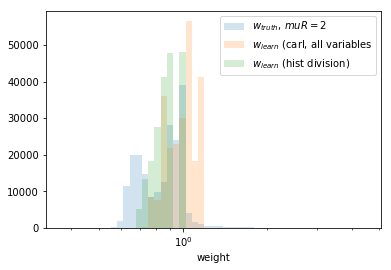

In [33]:
#histogram the weights with logarithmic binning
h = plt.hist(np.asarray(wMUR2.truthWeight),bins=np.exp(np.linspace(-1,1.5,50)),alpha=0.2,label="$w_{truth}$, $muR=2$")
h = plt.hist(carl_weights_roc,bins=np.exp(np.linspace(-1,1.5,50)),alpha=0.2,label="$w_{learn}$ (carl, %s variables)"%do)
h = plt.hist(np.asarray(wMUR2.learnWeight2D_MUR2),bins=np.exp(np.linspace(-1,1.5,50)),alpha=0.2,label="$w_{learn}$ (hist division)")
plt.semilogx()
plt.legend()
plt.xlabel("weight")
np.max(np.asarray(dfWMUR2.truthWeight)), np.max(carl_weights_roc)

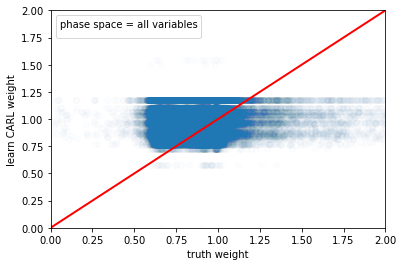

In [34]:
plt.scatter(np.asarray(wMUR2.truthWeight),carl_weights, alpha=0.01)
max_temp=2
plt.plot([0,max_temp],[0,max_temp], lw=2, c='r')
plt.xlim(0,max_temp)
plt.ylim(0,max_temp)
plt.xlabel('truth weight')
plt.ylabel('learned CARL weight')
plt.legend(title="phase space = %s variables"%do)
plt.savefig("plots/weight_compare_CARL_vs_truth_%sVariables.png" %(do))

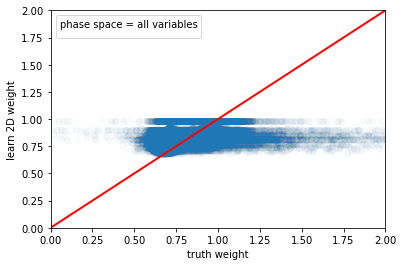

In [35]:
plt.scatter(np.asarray(wMUR2.truthWeight),np.asarray(wMUR2.learnWeight2D_MUR2), alpha=0.01)
max_temp=2
plt.plot([0,max_temp],[0,max_temp], lw=2, c='r')
plt.xlim(0,max_temp)
plt.ylim(0,max_temp)
plt.xlabel('truth weight')
plt.ylabel('learned histo. division weight')
plt.legend(title="phase space = %s variables"%do)
plt.savefig("plots/weight_compare_2D_vs_truth_%sVariables.png" %(do))

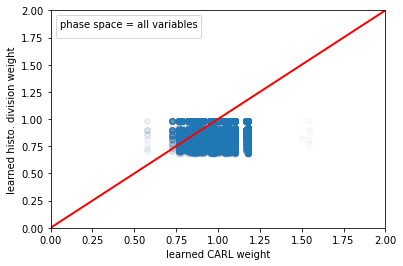

In [40]:
plt.scatter(carl_weights,np.asarray(wMUR2.learnWeight2D_MUR2), alpha=0.01)
max_temp=2
plt.plot([0,max_temp],[0,max_temp], lw=2, c='r')
plt.xlim(0,max_temp)
plt.ylim(0,max_temp)
plt.xlabel('learned CARL weight')
plt.ylabel('learned histo. division weight')
plt.legend(title="phase space = %s variables"%do)
plt.savefig("plots/weight_compare_2D_vs_CARL_%sVariables.png" %(do))

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

def weighted_discriminator_and_roc(original, target, weights):
    data = np.concatenate([original, target])
    labels = np.array([0] * len(original) + [1] * len(target))

    W = np.concatenate([weights / weights.sum() * len(target), [1] * len(target)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51, test_size = 0.49)
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=30).fit(Xtr, Ytr, sample_weight=Wtr)
    
    fpr, tpr, _  = roc_curve(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts)
    #roc_auc = auc(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts)
    roc_auc = auc(fpr, tpr,reorder=True)
    return fpr, tpr, roc_auc

/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x 

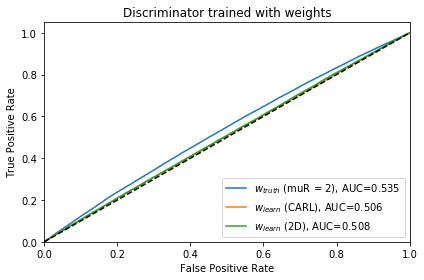

In [39]:
fpr_t,tpr_t,roc_auc_t = weighted_discriminator_and_roc(X0_rocMUR1, X1_roc, np.ones(X0_rocMUR1.shape[0]))
plt.plot(fpr_t, tpr_t, label=r"$w_{truth}$ (muR = 2), AUC=%.3f" % roc_auc_t)

fpr_t,tpr_t,roc_auc_t = weighted_discriminator_and_roc(X0_rocMUR1, X1_roc, carl_weights_roc)
plt.plot(fpr_t, tpr_t, label=r"$w_{learn}$ (CARL), AUC=%.3f" % roc_auc_t)

fpr_t,tpr_t,roc_auc_t = weighted_discriminator_and_roc(X0_rocMUR2, X1_roc, np.ones(X0_rocMUR2.shape[0]))
plt.plot(fpr_t, tpr_t, label=r"$w_{learn}$ (2D), AUC=%.3f" % roc_auc_t)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Discriminator trained with weights')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('plots/roc_weighted_%sVariables.png'%(do))